In [167]:
from tqdm import tqdm

import math
import random
import itertools
from functools import lru_cache

import torch
from torch import nn
import torch.nn.functional as F
from rotary_embedding_torch import RotaryEmbedding
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [168]:
"""
Features of the model:
- #TODO missing sign epistasis in this construction--because interactions are sampled independently, I might be missing some important correlation structure
- Multiple lengths
- Epistatic interactions are defined in terms of relative positions of elements in the sequence
- This means interaction types are shared but different positions have different interaction types available
- Boltzmann distribution for energy
- Interactions of upto order 4
- Interactions only increase the energy, so that the exponentials in the Boltzmann distribution are bounded
"""

'\nFeatures of the model:\n- #TODO missing sign epistasis in this construction--because interactions are sampled independently, I might be missing some important correlation structure\n- Multiple lengths\n- Epistatic interactions are defined in terms of relative positions of elements in the sequence\n- This means interaction types are shared but different positions have different interaction types available\n- Boltzmann distribution for energy\n- Interactions of upto order 4\n- Interactions only increase the energy, so that the exponentials in the Boltzmann distribution are bounded\n'

In [200]:
L_max = 10 # maximum sequence length
A = 3 # alphabet size
D_max = 3 # maximum order of interactions
distance_decay = 0.25 # for multi-position interactions, how quickly interaction strength decays with pairwise distance between positions
length_scale = 4.0 # controls energy term for sequence length
temperature = 1.0
N_seq_space = sum([A ** l for l in range(1, L_max + 1)]) # 1 is for the mask state, sum over all lengths less than L
N_data = sum([(A + 1) ** l for l in range(1, L_max + 1)]) # 1 is for the mask state, sum over all lengths less than L
print(N_seq_space, N_data)

88572 1398100


In [201]:
# Number of interactions needed
# WLOG consider the first position in the d interactors to be at position 0
# then there are L_max - 1 choose d - 1 ways to choose the other d - 1 positions
# Note a bunch of these terms won't be "physical" because the chosen position can be out of bounds for shorter lengths
N_interactions = sum([math.comb(L_max - 1, d - 1) * (A ** d) for d in range(1, D_max + 1)])
print(N_interactions)

1056


# Calculating Dataset Probabilities

In [202]:
# Energy function
# Interaction energies are deterministic
# TODO: should length decrease energy cost? Otherwise, just because there are more possible interactions, longer sequences will be disfavored
# Probability of interaction is exponential in the distance between each pair of positions
# Interaction contributions are geometrically distributed with support 1, 2, 3, ... with p=0.5 so mean 2
# We need to build up the interaction terms and then have a function to compute the energy of a sequence
# An easy way to do this is to make a helper function that takes a list of the positions and tokens, and outputting the interaction energy
# we can wrap this with a decorator to memoize it, that way it can be stochastic the first time but deterministic later

seq_to_str = lambda seq: ",".join(map(str, seq))
str_to_seq = lambda s: list(map(int, s.split(",")))

def translation_invariant_interaction(positions, tokens, distance_decay=distance_decay):
    # Sort positions in increasing order and remap tokens accordingly
    positions, tokens = str_to_seq(positions), str_to_seq(tokens)
    assert len(positions) == len(tokens)
    sorted_indices = sorted(range(len(positions)), key=lambda k: positions[k])
    positions = [positions[i] for i in sorted_indices]
    tokens = [tokens[i] for i in sorted_indices]
    positions = [p - min(positions) for p in positions] # make first position 0
    return base_interaction_sampler(seq_to_str(positions), seq_to_str(tokens), distance_decay)

@lru_cache(maxsize=None)
def base_interaction_sampler(positions, tokens, distance_decay=distance_decay):
    positions, tokens = str_to_seq(positions), str_to_seq(tokens)
    d = len(positions)
    # interaction strength
    interaction_distance = 0
    for i in range(d):
        for j in range(i + 1, d):
            # print(d)
            interaction_distance += positions[j] - positions[i]
    # interaction occurs with probability equal to strength (capped at 1)
    interaction_probability = math.exp(-distance_decay * interaction_distance)
    if interaction_probability < random.uniform(0, 1):
        return 0 # does into an exponential of the sum of energies so it doesn't change the overall energy 
    else:
        # if it is a vertex energy, we want the mean to be 1 not 2 since they are guaranteed to occur
        energy_cost = int(d > 1) + torch.distributions.geometric.Geometric(probs=0.5).sample().float()
        return energy_cost

@lru_cache(maxsize=None)
def position_aware_interaction(positions, tokens, distance_decay=distance_decay):
    # Sort positions in increasing order and remap tokens accordingly
    positions, tokens = str_to_seq(positions), str_to_seq(tokens)
    assert len(positions) == len(tokens)
    d = len(positions)
    sorted_indices = sorted(range(len(positions)), key=lambda k: positions[k])
    positions = [positions[i] for i in sorted_indices]
    tokens = [tokens[i] for i in sorted_indices]
    # interaction strength
    interaction_distance = 0
    for i in range(d):
        for j in range(i + 1, d):
            # print(d)
            interaction_distance += positions[j] - positions[i]
    # interaction occurs with probability equal to strength (capped at 1)
    interaction_probability = math.exp(-distance_decay * interaction_distance)
    if interaction_probability < random.uniform(0, 1):
        return 0 # does into an exponential of the sum of energies so it doesn't change the overall energy 
    else:
        # if it is a vertex energy, we want the mean to be 1 not 2 since they are guaranteed to occur
        energy_cost = int(d > 1) + torch.distributions.geometric.Geometric(probs=0.5).sample().float()
        return energy_cost

interaction = translation_invariant_interaction

@lru_cache(maxsize=None)
def unnorm_log_prob(sequence, temperature=temperature, length_scale=length_scale):
    # sequence is a list of integers in 0, ..., A-1
    sequence = str_to_seq(sequence)
    energy = 0
    for i in range(len(sequence)):
        for d in range(1, D_max + 1):
            if i + d <= len(sequence):
                # anchored at i so need to choose the other d - 1 positions
                for positions in itertools.combinations(range(i + 1, len(sequence)), d - 1):
                    positions = (i,) + positions
                    tokens = [sequence[p] for p in positions]
                    energy += interaction(seq_to_str(positions), seq_to_str(tokens))
    energy += length_scale * (L_max - len(sequence)) # correct a bit for length bias
    return -energy / temperature


@lru_cache(maxsize=None)
def partition_fn(temperature=temperature):
    # Compute the partition function Z = sum_{all sequences} exp(unnorm_log_prob)
    # Use log-sum-exp trick for numerical stability
    log_probs = []
    seqs = []
    for l in range(1, L_max + 1):
        for seq in tqdm(itertools.product(range(A), repeat=l), total=A**l, desc=f'Length {l}'):
            log_probs.append(unnorm_log_prob(seq_to_str(seq), temperature))
            seqs.append(seq)
    # log-sum-exp
    max_log_prob = max(log_probs)
    sum_exp = sum(math.exp(lp - max_log_prob) for lp in log_probs)
    Z = math.exp(max_log_prob) * sum_exp
    return Z, log_probs, seqs

@lru_cache(maxsize=None)
def prob(sequence, temperature=temperature):
    Z, log_probs, seqs = partition_fn(temperature)
    return math.exp(unnorm_log_prob(sequence, temperature)) / Z


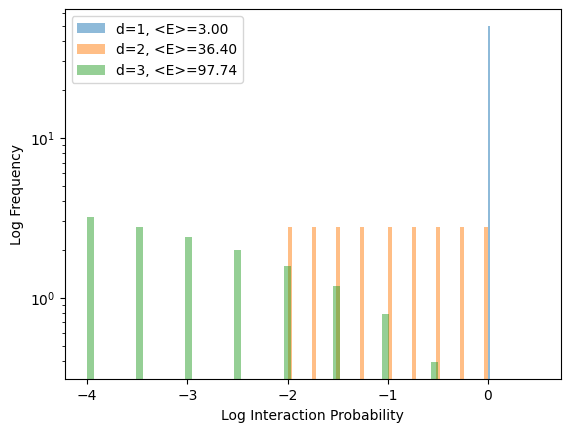

In [203]:
# Plot the histogram of interaction probabilities
for d in range(1, D_max + 1):
    interaction_costs = []
    expected_interactions = 0
    for positions in itertools.combinations(range(L_max - 1), d - 1):
        positions = (0,) + positions
        interaction_distance = 0
        for i in range(d):
            for j in range(i + 1, d):
                interaction_distance += positions[j] - positions[i]
        interaction_cost = -distance_decay * interaction_distance
        interaction_costs.append(interaction_cost)
        interaction_probability = math.exp(interaction_cost)
        expected_interactions += interaction_probability * (A ** d)
    plt.hist(interaction_costs, bins=50, alpha=0.5, label=f'd={d}, <E>={expected_interactions:.2f}', density=True, log=True)
plt.xlabel('Log Interaction Probability')
plt.ylabel('Log Frequency')
plt.legend()
plt.show()

Length 10: 100%|██████████| 59049/59049 [00:55<00:00, 1058.27it/s]


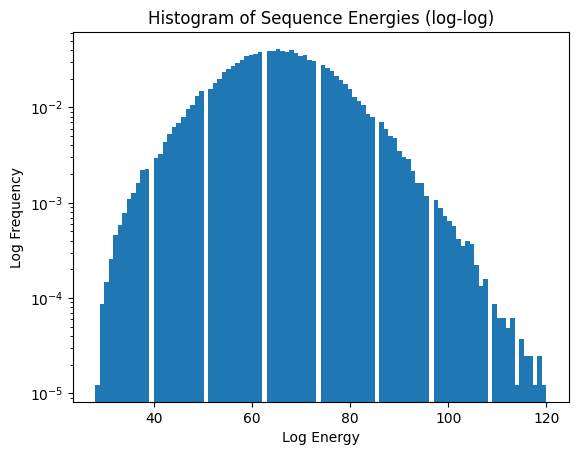

In [204]:
Z, log_probs, seqs = partition_fn(temperature=1.0)
energies = [math.exp(-lp) for lp in log_probs]
log_energies = [-lp for lp in log_probs]
plt.hist(log_energies, bins=100, log=True, density=True)
plt.xlabel('Log Energy')
plt.ylabel('Log Frequency')
plt.title('Histogram of Sequence Energies (log-log)')
plt.show()

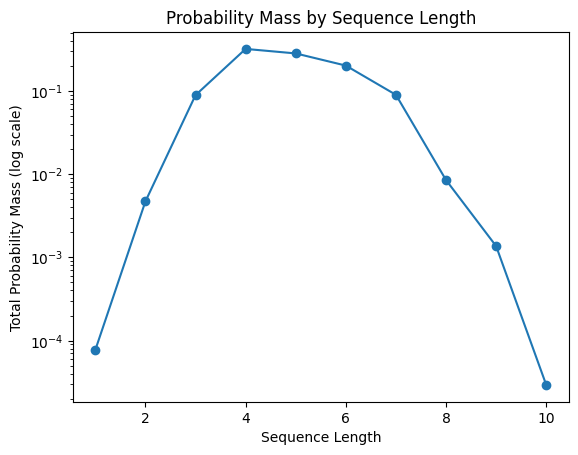

In [205]:
probs = np.exp(np.array(log_probs) - np.max(log_probs)) / np.sum(np.exp(np.array(log_probs) - np.max(log_probs)))
lengths = [len(seq) for seq in seqs]
prob_mass_by_length = [np.sum(probs[np.array(lengths) == l]) for l in range(1, max(lengths) + 1)]
plt.plot(range(1, max(lengths) + 1), prob_mass_by_length, marker='o')
plt.yscale('log')
plt.xlabel('Sequence Length')
plt.ylabel('Total Probability Mass (log scale)')
plt.title('Probability Mass by Sequence Length')
plt.show()

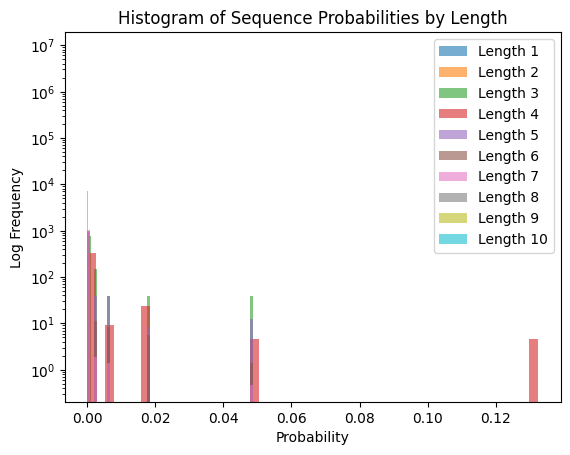

In [206]:
# Plot histograms of probabilities by sequence length
for l in range(1, max(lengths) + 1):
    plt.hist(probs[np.array(lengths) == l], bins=50, alpha=0.6, label=f'Length {l}', density=True, log=True)
plt.xlabel('Probability')
plt.ylabel('Log Frequency')
plt.title('Histogram of Sequence Probabilities by Length')
plt.legend()
plt.show()

# Model

In [207]:
class sequence_model(nn.Module):
    def __init__(self, L_max, A, D_max, d_model=16, n_head=1, n_layers=1):
        super(sequence_model, self).__init__()
        self.embedding = nn.Embedding(A + 1, d_model)
        self.n_layers = n_layers
        self.n_head = n_head
        self.d_model = d_model
        self.head_dim = d_model // n_head
        self.rope = RotaryEmbedding(dim=self.head_dim)
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'self_attn_q': nn.Linear(d_model, d_model),
                'self_attn_k': nn.Linear(d_model, d_model),
                'self_attn_v': nn.Linear(d_model, d_model),
                'self_attn_out': nn.Linear(d_model, d_model),
                'ffn1': nn.Linear(d_model, d_model),
                'ffn2': nn.Linear(d_model, d_model),
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model)
            }) for _ in range(n_layers)
        ])
        self.fc = nn.Linear(d_model, A)

    def forward(self, x_BL):
        x_embed_BLE = self.embedding(x_BL)
        seq_len = x_embed_BLE.size(1)
        mask_LL = torch.triu(torch.ones(seq_len, seq_len, device=x_BL.device), diagonal=1).bool()
        h_BLE = x_embed_BLE.clone()
        x_BLE = h_BLE.clone()
        for layer in self.layers:
            # Multi-head self-attention
            x_BLE = layer['norm1'](h_BLE)
            q_BLE = layer['self_attn_q'](x_BLE)
            k_BLE = layer['self_attn_k'](x_BLE)
            v_BLE = layer['self_attn_v'](x_BLE)
            # [batch, seq, d_model] -> [batch, seq, n_head, head_dim]
            def split_heads(t):
                return t.view(t.size(0), t.size(1), self.n_head, self.head_dim).transpose(1, 2)
            qh_BHLEh, kh_BHLEh, vh_BHLEh = split_heads(q_BLE), split_heads(k_BLE), split_heads(v_BLE)
            qh_BHLEh = self.rope.rotate_queries_or_keys(qh_BHLEh)
            kh_BHLEh = self.rope.rotate_queries_or_keys(kh_BHLEh)
            # Attention scores
            attn_scores_BHLL = torch.matmul(qh_BHLEh, kh_BHLEh.transpose(3, 2)) / math.sqrt(self.head_dim)
            attn_scores_BHLL = attn_scores_BHLL.masked_fill(mask_LL.unsqueeze(0).unsqueeze(1), float('-inf'))
            attn_weights_BHLL = torch.softmax(attn_scores_BHLL, dim=-1)
            attn_out_BHLEh = torch.matmul(attn_weights_BHLL, vh_BHLEh)
            # Merge heads and add to residual stream
            attn_out_BLE = attn_out_BHLEh.transpose(1, 2).contiguous().view(h_BLE.size(0), seq_len, self.d_model)
            attn_out_BLE = layer['self_attn_out'](attn_out_BLE)
            h_BLE = h_BLE + attn_out_BLE

            # Feedforward
            x_BLE = layer['norm2'](h_BLE)
            ff_BLE = layer['ffn2'](torch.relu(layer['ffn1'](x_BLE)))
            h_BLE = h_BLE + ff_BLE
        logits = self.fc(h_BLE)
        logits = F.log_softmax(logits, dim=-1)
        return logits


In [208]:
print(N_seq_space, len(np.array(energies)))

88572 88572


In [209]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
N_dataset = 500
N_mask = 200

# Split indices for train/val
# train_indices, val_indices = train_test_split(np.arange(N_seq_space), test_size=0.2, random_state=42, stratify=[len(seq) for seq in seqs])
train_indices, val_indices = train_test_split(np.arange(N_seq_space), test_size=0.2, random_state=42)

# Sample sequences for train/val using probs
train_sample_indices = np.random.choice(train_indices, size=(N_dataset,), replace=True, p=probs[train_indices]/probs[train_indices].sum())
val_sample_indices = np.random.choice(val_indices, size=(N_dataset // 5,), replace=True, p=probs[val_indices]/probs[val_indices].sum())

train_dataset = [seqs[i] for i in train_sample_indices]
val_dataset = [seqs[i] for i in val_sample_indices]

def make_masked_dataset(dataset, L_max, A, N_mask):
    Xt_by_length = [[] for _ in range(L_max)]
    X1_by_length = [[] for _ in range(L_max)]
    for seq in dataset:
        for _ in range(N_mask):
            n_masked = np.random.randint(1, len(seq) + 1)
            masked_positions = np.random.choice(len(seq), size=n_masked, replace=False)
            masked_seq = [A if i in masked_positions else seq[i] for i in range(len(seq))]
            Xt_by_length[len(seq) - 1].append(masked_seq)
            X1_by_length[len(seq) - 1].append(seq)
    print(torch.tensor(Xt_by_length[-1]).shape, torch.tensor(X1_by_length[-1]).shape)
    return [
        (torch.tensor(xt, dtype=torch.long).to(device), torch.tensor(x1, dtype=torch.long).to(device))
        for xt, x1 in zip(Xt_by_length, X1_by_length) if len(xt) > 0
    ]

train_datasets_by_length = make_masked_dataset(train_dataset, L_max, A, N_mask)
val_datasets_by_length = make_masked_dataset(val_dataset, L_max, A, N_mask)

train_dataset_lengths = [len(d[0]) for d in train_datasets_by_length]
val_dataset_lengths = [len(d[0]) for d in val_datasets_by_length]
print(train_dataset_lengths, val_dataset_lengths)

torch.Size([0]) torch.Size([0])
torch.Size([0]) torch.Size([0])
[200, 800, 11000, 31200, 25400, 27400, 3000, 800, 200] [5400, 8600, 800, 4800, 400]


In [210]:
batch_size = 128
epochs = 30
N_iterations = int(sum([l // batch_size + int(l % batch_size > 0) for l in val_dataset_lengths]) * epochs)
print(N_iterations, train_dataset_lengths)

4800 [200, 800, 11000, 31200, 25400, 27400, 3000, 800, 200]


In [211]:
model = sequence_model(L_max, A, D_max).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3, betas=(0.9, 0.98), eps=1e-9)
loss_weights = torch.zeros(A).to(device)
loss_weights[-1] = 1.0 # only care about the masked predictions
loss_fn = nn.NLLLoss(weight=loss_weights, ignore_index=-1)

In [212]:
from tqdm import trange

model.train()
for i in trange(N_iterations, desc="Training"):
    batch_seq_len_idx = np.random.choice(len(train_dataset_lengths), p=np.array(train_dataset_lengths) / sum(train_dataset_lengths))
    batch_dataset = train_datasets_by_length[batch_seq_len_idx]
    batch_indices = np.random.choice(len(batch_dataset[0]), size=min(batch_size, len(batch_dataset[0])), replace=False)
    Xt_batch_BL = batch_dataset[0][batch_indices]
    X1_batch_BL = batch_dataset[1][batch_indices]
    optimizer.zero_grad()
    logits_BLA = model(Xt_batch_BL)
    logits_x1_BL = logits_BLA.gather(2, X1_batch_BL.unsqueeze(-1)).squeeze(-1)
    loss = torch.sum(-logits_x1_BL * (Xt_batch_BL == A).float()) / torch.sum((Xt_batch_BL == A).float())
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        with torch.no_grad():
            model.eval()
            val_losses = []
            val_dataset_idx = np.random.choice(len(val_dataset_lengths), p=np.array(val_dataset_lengths) / sum(val_dataset_lengths))
            val_dataset = val_datasets_by_length[val_dataset_idx]
            val_batch_indices = np.random.choice(len(val_dataset[0]), size=min(batch_size, len(val_dataset[0])), replace=False)
            Xt_val_batch, X1_val_batch = (val_dataset[0][val_batch_indices], val_dataset[1][val_batch_indices])
            X1_val_batch = torch.where(Xt_val_batch == A, X1_val_batch, -1)
            val_logits = model(Xt_val_batch)
            val_loss = loss_fn(val_logits.view(-1, A), X1_val_batch.view(-1)).item()
            val_losses.append(val_loss)
            avg_val_loss = np.mean(val_losses) if val_losses else float('nan')
            print(f"Step {i}: train loss = {loss.item():.4f}, val loss = {avg_val_loss:.4f}")
            model.train()

Training:   0%|          | 16/4800 [00:00<00:30, 157.74it/s]

Step 0: train loss = 1.2193, val loss = 1.4951


Training:   2%|▏         | 119/4800 [00:00<00:28, 166.63it/s]

Step 100: train loss = 1.3545, val loss = 1.4763


Training:   5%|▍         | 222/4800 [00:01<00:27, 165.54it/s]

Step 200: train loss = 1.1594, val loss = 1.4382


Training:   7%|▋         | 324/4800 [00:01<00:26, 167.56it/s]

Step 300: train loss = 1.1541, val loss = 1.3628


Training:   9%|▉         | 427/4800 [00:02<00:26, 166.25it/s]

Step 400: train loss = 1.1378, val loss = 1.2613


Training:  11%|█         | 535/4800 [00:03<00:25, 169.64it/s]

Step 500: train loss = 1.1906, val loss = 1.2614


Training:  13%|█▎        | 620/4800 [00:03<00:24, 167.50it/s]

Step 600: train loss = 1.1345, val loss = 1.1843


Training:  15%|█▌        | 726/4800 [00:04<00:24, 167.18it/s]

Step 700: train loss = 1.0926, val loss = 1.1722


Training:  17%|█▋        | 829/4800 [00:04<00:24, 164.90it/s]

Step 800: train loss = 1.0895, val loss = 1.1133


Training:  19%|█▉        | 932/4800 [00:05<00:23, 164.99it/s]

Step 900: train loss = 1.0668, val loss = 1.0442


Training:  21%|██        | 1019/4800 [00:06<00:22, 166.19it/s]

Step 1000: train loss = 1.0065, val loss = 0.9636


Training:  23%|██▎       | 1123/4800 [00:06<00:22, 166.86it/s]

Step 1100: train loss = 1.0433, val loss = 0.9153


Training:  26%|██▌       | 1226/4800 [00:07<00:21, 166.26it/s]

Step 1200: train loss = 0.9520, val loss = 0.9365


Training:  28%|██▊       | 1330/4800 [00:07<00:20, 167.85it/s]

Step 1300: train loss = 1.0194, val loss = 0.8850


Training:  30%|██▉       | 1434/4800 [00:08<00:20, 167.26it/s]

Step 1400: train loss = 0.9075, val loss = 0.7961


Training:  32%|███▏      | 1519/4800 [00:09<00:19, 165.43it/s]

Step 1500: train loss = 1.0082, val loss = 0.7633


Training:  34%|███▍      | 1624/4800 [00:09<00:19, 165.89it/s]

Step 1600: train loss = 1.0306, val loss = 0.7718


Training:  36%|███▌      | 1730/4800 [00:10<00:18, 166.16it/s]

Step 1700: train loss = 0.8970, val loss = 0.7223


Training:  38%|███▊      | 1832/4800 [00:10<00:17, 164.96it/s]

Step 1800: train loss = 0.8618, val loss = 0.7229


Training:  40%|███▉      | 1919/4800 [00:11<00:17, 169.07it/s]

Step 1900: train loss = 1.0227, val loss = 0.6790


Training:  42%|████▏     | 2026/4800 [00:12<00:16, 170.96it/s]

Step 2000: train loss = 0.9976, val loss = 0.6276


Training:  44%|████▍     | 2133/4800 [00:12<00:15, 171.61it/s]

Step 2100: train loss = 1.0694, val loss = 0.6117


Training:  46%|████▋     | 2222/4800 [00:13<00:15, 166.63it/s]

Step 2200: train loss = 1.0644, val loss = 0.6223


Training:  48%|████▊     | 2324/4800 [00:13<00:15, 164.25it/s]

Step 2300: train loss = 0.7488, val loss = 0.6233


Training:  51%|█████     | 2428/4800 [00:14<00:14, 168.24it/s]

Step 2400: train loss = 1.0806, val loss = 0.5880


Training:  53%|█████▎    | 2532/4800 [00:15<00:13, 166.31it/s]

Step 2500: train loss = 1.0117, val loss = 0.5511


Training:  55%|█████▍    | 2634/4800 [00:15<00:13, 165.64it/s]

Step 2600: train loss = 1.0241, val loss = 0.5567


Training:  57%|█████▋    | 2720/4800 [00:16<00:12, 168.07it/s]

Step 2700: train loss = 1.0680, val loss = 0.5520


Training:  59%|█████▉    | 2825/4800 [00:16<00:11, 164.66it/s]

Step 2800: train loss = 0.7763, val loss = 0.5390


Training:  61%|██████    | 2929/4800 [00:17<00:11, 166.88it/s]

Step 2900: train loss = 0.6659, val loss = 0.5157


Training:  63%|██████▎   | 3031/4800 [00:18<00:10, 163.72it/s]

Step 3000: train loss = 0.7238, val loss = 0.5259


Training:  65%|██████▌   | 3133/4800 [00:18<00:10, 164.69it/s]

Step 3100: train loss = 0.7676, val loss = 0.5098


Training:  67%|██████▋   | 3219/4800 [00:19<00:09, 167.18it/s]

Step 3200: train loss = 0.7737, val loss = 0.5063


Training:  69%|██████▉   | 3321/4800 [00:19<00:08, 165.30it/s]

Step 3300: train loss = 0.8705, val loss = 0.5150


Training:  71%|███████▏  | 3423/4800 [00:20<00:08, 166.08it/s]

Step 3400: train loss = 0.6554, val loss = 0.5127


Training:  73%|███████▎  | 3527/4800 [00:21<00:07, 164.83it/s]

Step 3500: train loss = 1.0672, val loss = 0.5050


Training:  76%|███████▌  | 3634/4800 [00:21<00:06, 168.72it/s]

Step 3600: train loss = 0.6371, val loss = 0.5028


Training:  77%|███████▋  | 3719/4800 [00:22<00:06, 165.29it/s]

Step 3700: train loss = 1.0692, val loss = 0.5008


Training:  80%|███████▉  | 3822/4800 [00:22<00:05, 167.71it/s]

Step 3800: train loss = 0.7685, val loss = 0.4833


Training:  82%|████████▏ | 3926/4800 [00:23<00:05, 168.08it/s]

Step 3900: train loss = 1.0284, val loss = 0.4902


Training:  84%|████████▍ | 4030/4800 [00:24<00:04, 166.11it/s]

Step 4000: train loss = 0.7933, val loss = 0.4973


Training:  86%|████████▌ | 4133/4800 [00:24<00:04, 165.27it/s]

Step 4100: train loss = 0.6931, val loss = 0.4964


Training:  88%|████████▊ | 4219/4800 [00:25<00:03, 164.37it/s]

Step 4200: train loss = 0.7931, val loss = 0.4954


Training:  90%|█████████ | 4322/4800 [00:25<00:02, 167.65it/s]

Step 4300: train loss = 1.0595, val loss = 0.4857


Training:  92%|█████████▏| 4424/4800 [00:26<00:02, 164.40it/s]

Step 4400: train loss = 1.1021, val loss = 0.4765


Training:  94%|█████████▍| 4526/4800 [00:27<00:01, 163.95it/s]

Step 4500: train loss = 0.6199, val loss = 0.4922


Training:  96%|█████████▋| 4629/4800 [00:27<00:01, 164.31it/s]

Step 4600: train loss = 0.6630, val loss = 0.4824


Training:  99%|█████████▊| 4734/4800 [00:28<00:00, 169.00it/s]

Step 4700: train loss = 1.0204, val loss = 0.4894


Training: 100%|██████████| 4800/4800 [00:28<00:00, 166.68it/s]


# Compare Sampling

In [213]:
num_samples = 1000
# Sample sequences from the dataset distribution
sampled_dataset_indices = np.random.choice(len(seqs), size=num_samples, replace=True, p=probs)
sampled_dataset = [seqs[i] for i in sampled_dataset_indices]
sampled_dataset_probs = [prob(seq_to_str(seq), temperature=1.0) for seq in sampled_dataset]
print("Sampled dataset sequences and probabilities:")
for i in range(num_samples):
    seq = sampled_dataset[i]
    seq_prob = sampled_dataset_probs[i]
    print(f"Sequence {i}: {seq}, Probability: {seq_prob:.4e}")

Length 10: 100%|██████████| 59049/59049 [00:00<00:00, 938618.30it/s]


Sampled dataset sequences and probabilities:
Sequence 0: (0, 0, 1, 0, 0, 0, 0), Probability: 1.2076e-04
Sequence 1: (1, 1, 2), Probability: 2.4254e-03
Sequence 2: (0, 2, 1), Probability: 3.2825e-04
Sequence 3: (1, 2, 2, 2, 2, 2), Probability: 2.4254e-03
Sequence 4: (1, 2, 0, 0), Probability: 8.9227e-04
Sequence 5: (1, 0, 0), Probability: 2.4254e-03
Sequence 6: (1, 0, 2, 0), Probability: 1.2076e-04
Sequence 7: (2, 2, 2, 2, 1), Probability: 4.8716e-02
Sequence 8: (1, 1, 1, 1, 2, 2), Probability: 3.2825e-04
Sequence 9: (2, 2, 2, 2, 1), Probability: 4.8716e-02
Sequence 10: (2, 2, 2, 2), Probability: 1.3242e-01
Sequence 11: (2, 2, 2, 2, 2), Probability: 4.8716e-02
Sequence 12: (2, 1, 1, 2, 2, 2, 1), Probability: 3.2825e-04
Sequence 13: (1, 2, 1, 0, 0), Probability: 4.8716e-02
Sequence 14: (1, 2, 1, 0, 1, 1), Probability: 6.5930e-03
Sequence 15: (2, 2, 2, 2, 1, 2, 2), Probability: 4.8716e-02
Sequence 16: (2, 1, 1, 2, 2, 2), Probability: 8.9227e-04
Sequence 17: (1, 2, 2), Probability: 1.7922e

In [214]:
sampled_sequences = []
sampled_probs = []
sampled_model_probs = []

lengths = [len(seq) for seq in seqs]
probs = np.exp(np.array(log_probs) - np.max(log_probs)) / np.sum(np.exp(np.array(log_probs) - np.max(log_probs)))
lengths_arr = np.array(lengths)
length_prob_mass = np.array([np.sum(probs[lengths_arr == l]) for l in range(1, L_max + 1)])
length_prob_mass /= length_prob_mass.sum()

model.eval()
with torch.no_grad():
    for _ in range(num_samples):
        seq_len = np.random.choice(np.arange(1, L_max + 1), p=length_prob_mass)
        ordering = np.random.permutation(seq_len)
        seq = [A] * seq_len  # Start with all masked
        model_prob = 1.0
        for idx in ordering:
            input_seq = torch.tensor([seq], dtype=torch.long).to(device)
            logp_BLA = model(input_seq)[0, idx]
            probs_BLA = torch.exp(logp_BLA)
            token = torch.multinomial(probs_BLA, num_samples=1).item()
            model_prob *= probs_BLA[token].item()
            seq[idx] = token
        sampled_sequences.append(seq)
        sampled_model_probs.append(model_prob)
        sampled_probs.append(prob(seq_to_str(seq), temperature=1.0))

for seq, p_model, p_actual in zip(sampled_sequences, sampled_model_probs, sampled_probs):
    print(f"Sequence: {seq}, Probability: {p_model:.4e}, Actual Prob: {p_actual:.4e}")

Sequence: [2, 0, 2, 1, 1, 2, 2], Probability: 1.2887e-03, Actual Prob: 2.9932e-07
Sequence: [2, 1, 0, 1, 1, 2, 0], Probability: 1.2217e-04, Actual Prob: 6.0121e-06
Sequence: [2, 2, 1, 1, 0, 2], Probability: 2.6028e-03, Actual Prob: 8.1364e-07
Sequence: [2, 2, 1, 2, 1], Probability: 1.7510e-02, Actual Prob: 3.2825e-04
Sequence: [2, 2, 2], Probability: 2.3246e-01, Actual Prob: 4.8716e-02
Sequence: [2, 2, 2, 2, 2, 2], Probability: 4.2000e-02, Actual Prob: 1.7922e-02
Sequence: [2, 1, 2, 1], Probability: 2.5171e-02, Actual Prob: 1.7922e-02
Sequence: [2, 1, 2, 0, 1], Probability: 3.8884e-03, Actual Prob: 1.2076e-04
Sequence: [0, 2, 2, 0, 2], Probability: 2.9291e-03, Actual Prob: 1.4902e-08
Sequence: [2, 2, 0, 1], Probability: 1.2013e-02, Actual Prob: 3.2825e-04
Sequence: [1, 1, 2, 2, 2], Probability: 1.6645e-02, Actual Prob: 2.4254e-03
Sequence: [2, 2, 2, 0, 0, 2], Probability: 2.0927e-03, Actual Prob: 1.1011e-07
Sequence: [2, 2, 2, 1, 1], Probability: 1.7080e-02, Actual Prob: 6.5930e-03
Seq

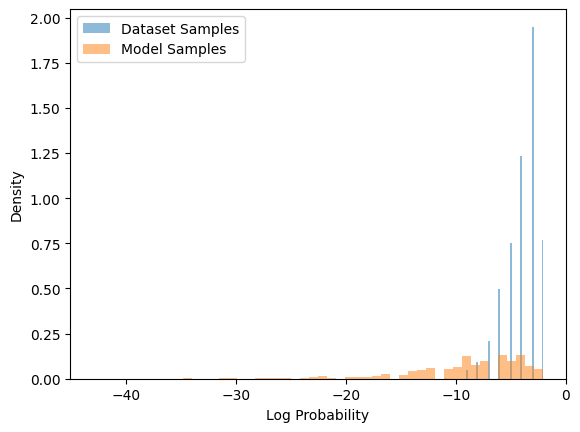

In [215]:
plt.hist(np.log(sampled_dataset_probs), bins=50, alpha=0.5, label='Dataset Samples', density=True)
plt.hist(np.log(sampled_probs), bins=50, alpha=0.5, label='Model Samples', density=True)
plt.xlabel('Log Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

In [216]:
purity_sampled_sequences = []
purity_sampled_probs = []
purity_sampled_model_probs = []

model.eval()
with torch.no_grad():
    for _ in range(num_samples // 10):
        seq_len = np.random.choice(np.arange(1, L_max + 1), p=length_prob_mass)
        seq = [A] * seq_len  # Start with all masked
        model_prob = 1.0
        input_seq = torch.tensor([seq], dtype=torch.long).to(device)
        for t in range(seq_len):
            masked_pos_BL = input_seq == A
            logp_BLA = model(input_seq)
            probs_BLA = torch.exp(logp_BLA)
            entropy_BL = -torch.sum(probs_BLA * logp_BLA, dim=2)
            entropy_BL += (1 - masked_pos_BL.float()) * float("inf")  # large penalty for unmasked positions
            idx = torch.argmin(entropy_BL, dim=1)
            token = torch.multinomial(probs_BLA[0, idx], num_samples=1).item()
            model_prob *= probs_BLA[0, idx, token].item()
            input_seq[0, idx] = token
        purity_sampled_sequences.append(input_seq[0].cpu().numpy().tolist())
        purity_sampled_model_probs.append(model_prob)
        purity_sampled_probs.append(prob(seq_to_str(seq), temperature=1.0))

for seq, p_model, p_actual in zip(purity_sampled_sequences, purity_sampled_model_probs, purity_sampled_probs):
    print(f"Sequence: {seq}, Probability: {p_model:.4e}, Actual Prob: {p_actual:.4e}")

Sequence: [2, 1, 2, 0], Probability: 1.4069e-02, Actual Prob: 3.5997e-01
Sequence: [2, 2, 2, 2], Probability: 1.2708e-01, Actual Prob: 3.5997e-01
Sequence: [2, 2, 2, 2, 1, 1], Probability: 1.0900e-02, Actual Prob: 2.6598e+00
Sequence: [1, 2, 1, 2, 2], Probability: 1.4303e-02, Actual Prob: 9.7849e-01
Sequence: [2, 2, 0], Probability: 5.1710e-02, Actual Prob: 1.7922e-02
Sequence: [2, 0, 2, 2], Probability: 2.5226e-02, Actual Prob: 3.5997e-01
Sequence: [2, 1, 2, 2, 2, 2, 0], Probability: 2.8621e-03, Actual Prob: 3.5997e-01
Sequence: [2, 2, 2, 2, 2], Probability: 7.0105e-02, Actual Prob: 9.7849e-01
Sequence: [2, 2, 1, 1, 2], Probability: 1.7025e-02, Actual Prob: 9.7849e-01
Sequence: [2, 2, 0], Probability: 5.1710e-02, Actual Prob: 1.7922e-02
Sequence: [1, 2, 1, 1, 1, 2], Probability: 2.1516e-03, Actual Prob: 2.6598e+00
Sequence: [2, 1, 1, 2, 1, 2], Probability: 4.5392e-03, Actual Prob: 2.6598e+00
Sequence: [2, 2, 2, 2, 2], Probability: 7.0105e-02, Actual Prob: 9.7849e-01
Sequence: [2, 2, 1

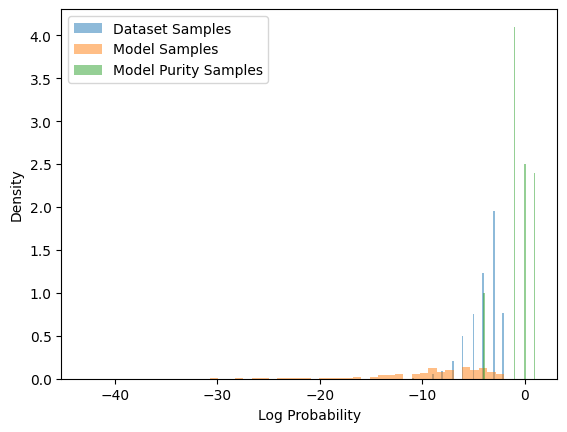

In [217]:
plt.hist(np.log(sampled_dataset_probs), bins=50, alpha=0.5, label='Dataset Samples', density=True)
plt.hist(np.log(sampled_probs), bins=50, alpha=0.5, label='Model Samples', density=True)
plt.hist(np.log(purity_sampled_probs), bins=50, alpha=0.5, label='Model Purity Samples', density=True)
plt.xlabel('Log Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

# Order Training

In [218]:
# Make a dataset of the val label sequences as one-hot tensors, the logits for a partially masked input, and the masks
# train a model to predict a distribution over positions in order to minimize the entropy of the nll of the true labels
# ie minimize the dot product of the position probabilities and the nll of the true labels at each position (minimize surprise of true label)

